In [7]:
import os
from pathlib import Path

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sourmash import fig

In [2]:
proj_dir = "/master/nplatt/sch_hae_scan"
results_dir = f"{proj_dir}/results"
os.chdir(results_dir)

In [3]:
pca_df = pd.read_csv(f"{proj_dir}/results/pca/pca_df.csv", sep=",")

In [4]:
info_df = pd.read_csv(
    "{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir)
)

# kraken

In [8]:
Path(f"{proj_dir}/results/kraken").mkdir(parents=True, exist_ok=True)
os.chdir(f"{proj_dir}/results/kraken")

In [ ]:
#!wget https://genome-idx.s3.amazonaws.com/kraken/k2_nt_20231129.tar.gz

In [12]:
!cat ../pca/pca_df.csv | cut -f1 -d"," | sed 1d >samples.list

In [ ]:
%%bash

QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 48 " 

for SAMPLE in $(cat samples.list); do
        #echo $SAMPLE

        C="0.2"
        R1="/master/nplatt/sch_hae_scan/data/seq_data/${SAMPLE}_R1.fq.gz"
        R2="/master/nplatt/sch_hae_scan/data/seq_data/${SAMPLE}_R2.fq.gz"
        REP="${SAMPLE}.report.txt"
        TABLE="${SAMPLE}.table.tsv"
        LOG="${SAMPLE}.log.txt"
   
        CMD="conda activate kraken; kraken2 \
            --use-names \
            --threads 36 \
            --db scan \
            --report ${REP} \
            --paired \
            --confidence 0.4 \
            --output $TABLE \
            ${R1} \
            ${R2} \
            >${LOG} 2>&1"

        echo $CMD | $QSUB -N k2.$SAMPLE -o $SAMPLE.sge.log
done

In [ ]:
%%bash

#31245 = Schistosomatidae taxonomy id.

QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 24 " 

for SAMPLE in $(cat samples.list); do
    
        R1="/master/nplatt/sch_hae_scan/data/seq_data/${SAMPLE}_R1.fq.gz"
        R2="/master/nplatt/sch_hae_scan/data/seq_data/${SAMPLE}_R2.fq.gz"
        REP="${SAMPLE}.report.txt"
        TABLE="${SAMPLE}.table.tsv"
        O_R1="${SAMPLE}.schisto.R1.fq"
        O_R2="${SAMPLE}.schisto.R2.fq"

        CMD="conda run -n kraken extract_kraken_reads.py -k $TABLE -s $R1 -s $R2 -t 31245 -o $O_R1  -o2 $O_R2 --report $REP --include-children --fastq-output"
        
    echo $CMD | $QSUB -N extract.$SAMPLE -o $SAMPLE.extract.log

done

In [ ]:
#plot somehow

# Sourmash

In [5]:
Path(f"{proj_dir}/results/sourmash").mkdir(parents=True, exist_ok=True)
os.chdir(f"{proj_dir}/results/sourmash")

In [6]:
!cat ../pca/pca_df.csv | cut -f1 -d"," | sed 1d >samples.list

In [ ]:
%%bash

QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 24 " 

for SAMPLE in $(cat samples.list); do
    
        R1="/master/nplatt/sch_hae_scan/results/kraken/${SAMPLE}.schisto.R1.fq"
        R2="/master/nplatt/sch_hae_scan/results/kraken/${SAMPLE}.schisto.R2.fq"

    CMD="conda run -n khmer trim-low-abund.py -C 3 -Z 18 -V -M 6e10 -k 31 -o $SAMPLE.abund_trimmed.fq  $R1 $R2"

    echo $CMD | $QSUB -N khmer.$SAMPLE -o $SAMPLE.trim-low-abund.log
done

In [ ]:
%%bash

QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 24 " 

for SAMPLE in $(cat samples.list); do
    CMD="conda run -n sourmash sourmash sketch dna -p scaled=1000,k=31,k=51 ${SAMPLE}.abund_trimmed.fq -o ${SAMPLE}.sig"
    echo $CMD | $QSUB -N sourmash.${SAMPLE} -o ${SAMPLE}.sketch.log -hold_jid khmer.$SAMPLE
done

In [ ]:
%%bash

sourmash compare $(ls *.sig) -o compare-demo -k 31

In [10]:
matrix, labels = fig.load_matrix_and_labels("compare-demo")

In [8]:
# print("matrix:\n", matrix)
# print("labels:", labels)

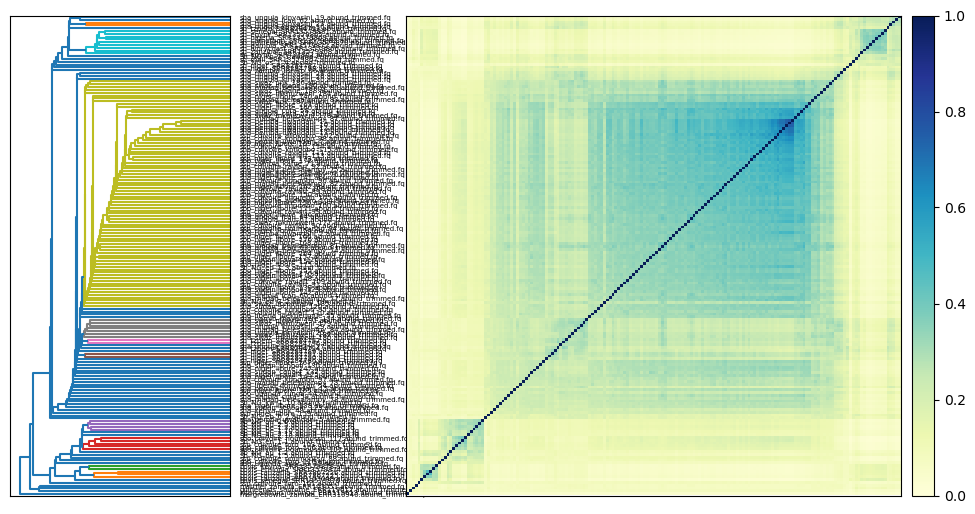

In [11]:
f, reordered_labels, reordered_matrix = fig.plot_composite_matrix(matrix, labels)
f.savefig("31_kmer.png", dpi=600, facecolor="white")
f.savefig("31_kmer.svg")

In [9]:
# print("reordered matrix:\n", reordered_matrix)
# print("reordered labels:", reordered_labels)